# Load data and create the 'data' DataFrame

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
#!pip install mwtab

In [3]:
import mwtab

mwfile = next(mwtab.read_files("ST002087_AN003405.txt"))

# list MWTabFile-level keys, i.e. saveframe names
list(mwfile.keys())

['METABOLOMICS WORKBENCH',
 'PROJECT',
 'STUDY',
 'SUBJECT',
 'SUBJECT_SAMPLE_FACTORS',
 'COLLECTION',
 'TREATMENT',
 'SAMPLEPREP',
 'ANALYSIS',
 'NM',
 'NMR_METABOLITE_DATA']

In [4]:
# access "PROJECT" block
mwfile["PROJECT"]

OrderedDict([('PROJECT_TITLE',
              'Profiling metabolites and lipoproteins in COMETA, an Italian cohort of COVID-19 patients'),
             ('PROJECT_TYPE', 'NMR-based metabolomics'),
             ('PROJECT_SUMMARY',
              '1H NMR spectra of EDTA-plasma from 246 COVID-19-positive subjects in the acute phase of infection were compared to those of 95 COVID-19-recovered subjects. The two cohorts are largely different (discrimination accuracy &gt; 93%) due to a pool of 16 metabolites and 74 lipoprotein parameters significantly up- or down-regulated in the patients and within the healthy range in the recovered subjects. In 28 post-acute COVID-19-positive patients, the metabolites levels are reverted back to normality whereas the lipoprotein parameters are still altered. Therefore, the metabolite biomarkers might be used as the timeliest sign of the individual response to treatment or spontaneous healing.'),
             ('INSTITUTE', 'University of Florence'),
           

In [5]:
# access "SUBJECT_SAMPLE_FACTORS" block and print first three
mwfile["SUBJECT_SAMPLE_FACTORS"][0].keys()

odict_keys(['Subject ID', 'Sample ID', 'Factors', 'Additional sample data'])

In [6]:
mwfile["SUBJECT_SAMPLE_FACTORS"][0].values()

odict_values(['6', '6', {'Grade of severity': 'Asymptomatic', 'Group': 'COVID-19&lt;21days'}, {'RAW_FILE_NAME': '6', 'SEX': 'male', 'AGE': '72'}])

In [7]:
# Extract values from the dictionary
sample_id_all=[]
severity_all=[]
group_all=[]
sex_all=[]
age_all=[]

for i in range(len(mwfile["SUBJECT_SAMPLE_FACTORS"])):
    
    temp_list=list(mwfile["SUBJECT_SAMPLE_FACTORS"][i].values())[1:]
    
    sample_id=temp_list[0]
    sample_id_all.append(sample_id)
    
    severity=list(temp_list[1].values())[0]
    severity_all.append(severity)
    
    group=list(temp_list[1].values())[1]
    group_all.append(group)
    
    sex=list(temp_list[2].values())[1]
    sex_all.append(sex)
    
    age=list(temp_list[2].values())[2]
    age_all.append(age)

In [8]:
# Make DataFrame
df_patients_info=pd.DataFrame(sample_id_all, columns=["sample_id"])
df_patients_info["severity"]=severity_all
df_patients_info["group"]=group_all
df_patients_info["sex"]=sex_all
df_patients_info["age"]=age_all

df_patients_info

,sample_id,severity,group,sex,age
0,6,Asymptomatic,COVID-19&lt;21days,male,72
1,7,Asymptomatic,COVID-19&lt;21days,female,89
2,9,Asymptomatic,COVID-19&lt;21days,female,82
3,19,Asymptomatic,COVID-19&lt;21days,male,56
4,20,Asymptomatic,COVID-19&lt;21days,male,87
...,...,...,...,...,...
363,181,Severe,Post-COVID-109,female,74
364,189,Severe,Post-COVID-110,male,57
365,278,Severe,Post-COVID-111,male,72
366,279,Severe,Post-COVID-112,male,79


In [9]:
# Fix the strings in the 'group' column
df_patients_info['group'] = df_patients_info['group'].str.replace('&lt;','<')
df_patients_info['group'] = df_patients_info['group'].str.replace('&gt;','>')

# Replace the strings 'Post-COVID-number' with 'Post-COVID'
group=df_patients_info['group'].str.split('ost-COVID', expand=True)
group=group[0]
group=group.str.replace('P', 'Post-COVID')

df_patients_info['group'] = group

In [10]:
# access data block keys
list(mwfile["NMR_METABOLITE_DATA"].keys())

['Units', 'Data', 'Metabolites']

In [11]:
mwfile["NMR_METABOLITE_DATA"]["Units"]

'uM'

In [12]:
mwfile["NMR_METABOLITE_DATA"]["Metabolites"][:3]

[OrderedDict([('Metabolite', 'Alanine'), ('KEGG ID', 'C00041\xa0\xa0')]),
 OrderedDict([('Metabolite', 'Creatine'), ('KEGG ID', 'C00300')]),
 OrderedDict([('Metabolite', 'Creatinine'), ('KEGG ID', 'C00791')])]

In [13]:
print(list(mwfile["NMR_METABOLITE_DATA"]["Data"][0].keys())[:5])
print(list(mwfile["NMR_METABOLITE_DATA"]["Data"][0].values())[:5])

print("Number of metabolites:", len(list(mwfile["NMR_METABOLITE_DATA"]["Data"])))

['Metabolite', '4', '5', '6', '7']
['Alanine', '0.193', '0.535', '0.411', '0.379']
Number of metabolites: 139


**Comment:** Each datapoint in mwfile["NMR_METABOLITE_DATA"]["Data"] corresponds to a quantity of a metabolite for each of the 369 samples (patients). There are 139 metabolites.

In [14]:
# Create DataFrame with all metabolites quntities for each patient.

metabolite_quantity_all=[]
metabolite_name_all=[]

for entry in range(len(mwfile["NMR_METABOLITE_DATA"]["Data"])): # Loop over the 139 metabolites
    
    # Take metabolite quantity for each patient, ignore the first entry which is the name of the metabolite, convert to float
    metabolite_quantity=list(map(float,list(mwfile["NMR_METABOLITE_DATA"]["Data"][entry].values())[1:])) 
    metabolite_quantity_all.append(metabolite_quantity)
    
    # Take the first entry which is the name of the metabolite
    metabolite_name=list(mwfile["NMR_METABOLITE_DATA"]["Data"][entry].values())[0]  
    metabolite_name_all.append(metabolite_name)

In [15]:
# Total number of metabolites
len(metabolite_name_all)

139

In [16]:
# Distinguish between what is strictly a metabolite in contrast to other substances present, for example lipids.
metabolite_not_lipid=['Alanine','Creatine','Creatinine','Glutamine','Glycine','Histidine','Isoleucine','Leucine','Methionine','Ornithine',
                      'Phenylalanine','Tyrosine','Valine','Aceticacid','Citricacid','Formicacid',
                      'Lacticacid','Succinicacid','3-Hydroxybutyricacid','Acetoaceticacid','Acetone','Pyruvicacid','Glucose','Glycoproteins','Mannose']
print('Number of small metabolites', len(metabolite_not_lipid))
%store metabolite_not_lipid

lipid=set(metabolite_name_all)-set(metabolite_not_lipid)
print('Number of lipids', len(lipid))
%store lipid

Number of small metabolites 25
Stored 'metabolite_not_lipid' (list)
Number of lipids 114
Stored 'lipid' (set)


In [17]:
# Make DataFrame with the metabolites
df=pd.DataFrame(metabolite_quantity_all).T
df.columns=metabolite_name_all
sample_id=list(mwfile["NMR_METABOLITE_DATA"]["Data"][0].keys())[1:]
df.insert(0, 'sample_id', sample_id)
df.head(5)

,sample_id,Alanine,Creatine,Creatinine,Glutamine,Glycine,Histidine,Isoleucine,Leucine,Methionine,...,Phospholipids_HDL3,Phospholipids_HDL4,ApoA1_HDL1,ApoA1_HDL2,ApoA1_HDL3,ApoA1_HDL4,ApoA2_HDL1,ApoA2_HDL2,ApoA2_HDL3,ApoA2_HDL4
0,4,0.193,0.135,0.061,0.847,0.298,0.000,0.065,0.053,0.004,...,14.67,18.34,44.91,22.60,21.16,45.96,4.64,3.42,3.90,9.20
1,5,0.535,0.021,0.072,0.788,0.334,0.000,0.075,0.090,0.005,...,17.84,42.19,14.25,19.62,26.83,110.26,2.01,2.94,6.19,31.74
2,6,0.411,0.016,0.088,0.705,0.274,0.063,0.077,0.119,0.022,...,10.74,23.66,11.70,12.89,19.43,65.81,1.02,1.57,3.40,15.17
3,7,0.379,0.018,0.069,0.696,0.538,0.034,0.062,0.082,0.000,...,13.72,27.79,14.14,14.83,23.45,77.41,1.57,2.77,5.49,18.97
4,8,0.469,0.006,0.071,0.696,0.320,0.064,0.044,0.081,0.012,...,21.08,36.49,36.48,26.34,36.24,97.67,5.09,5.76,8.84,26.49


## Merge dataframes with patients and metabolites information

In [18]:
# Merge the dataframe with substances quantities and patients information
data=pd.merge(df_patients_info, df, on='sample_id')
data.to_csv('data.csv', index=False)
data.head()

,sample_id,severity,group,sex,age,Alanine,Creatine,Creatinine,Glutamine,Glycine,...,Phospholipids_HDL3,Phospholipids_HDL4,ApoA1_HDL1,ApoA1_HDL2,ApoA1_HDL3,ApoA1_HDL4,ApoA2_HDL1,ApoA2_HDL2,ApoA2_HDL3,ApoA2_HDL4
0,6,Asymptomatic,COVID-19<21days,male,72,0.411,0.016,0.088,0.705,0.274,...,10.74,23.66,11.70,12.89,19.43,65.81,1.02,1.57,3.40,15.17
1,7,Asymptomatic,COVID-19<21days,female,89,0.379,0.018,0.069,0.696,0.538,...,13.72,27.79,14.14,14.83,23.45,77.41,1.57,2.77,5.49,18.97
2,9,Asymptomatic,COVID-19<21days,female,82,0.362,0.058,0.117,0.657,0.311,...,14.81,25.25,25.53,17.31,24.52,71.67,2.75,3.58,5.84,17.22
3,19,Asymptomatic,COVID-19<21days,male,56,0.394,0.007,0.100,0.783,0.227,...,10.61,23.90,10.68,11.57,15.62,65.09,1.16,2.20,4.29,17.87
4,20,Asymptomatic,COVID-19<21days,male,87,0.224,0.122,0.155,0.452,0.220,...,14.48,17.27,15.86,15.26,22.83,44.42,2.40,3.93,6.29,9.79


## Check for missing values

In [19]:
# Show number of NaN in the entire DataFrame
data.isnull().sum().sum()

0

In [20]:
# Count how many times each data type is present in the dataset
print(pd.value_counts(data.dtypes))

# Make a dictionary to store the column names of columns of the same data type
data_types_columns={}
for i in range(len(pd.value_counts(data.dtypes))):
    data_types_columns["col_{0}".format(pd.value_counts(data.dtypes).index[i])]=data.select_dtypes(include=pd.value_counts(data.dtypes).index[i]).columns
    
# Create separate lists    
col_float64=data_types_columns["col_float64"]
col_object=data_types_columns["col_object"]

float64    139
object       5
dtype: int64


In [21]:
# Have a look at the object columns
col_object

Index(['sample_id', 'severity', 'group', 'sex', 'age'], dtype='object')

In [22]:
print(data['severity'].unique())
print(data['group'].unique())
print(data['sex'].unique())

['Asymptomatic' 'Mild' 'Moderate' 'Severe']
['COVID-19<21days' 'COVID-19>21days' 'Post-COVID']
['male' 'female']


## Encode features

In [23]:
# Change format and encode the features
data['age']=data['age'].astype('int64')

scale_mapper_severity = {'Asymptomatic':0, 'Mild':1, 'Moderate':2, 'Severe':3}
data['severity'] = data['severity'].replace(scale_mapper_severity)

scale_mapper_group = {'Post-COVID':0, 'COVID-19>21days':1, 'COVID-19<21days':2}
data['group'] = data['group'].replace(scale_mapper_group)

scale_mapper_sex = {'female':0, 'male':1}
data['sex'] = data['sex'].replace(scale_mapper_sex )

In [24]:
# Create categories for the 'age' parameter
conditions = [
    (data['age'] <= 50),
    (data['age'] > 50) & (data['age'] <= 70),
    (data['age'] > 70) & (data['age'] <= 85),
    (data['age'] > 85)
]

# create a list of the values we want to assign for each condition
values = ['0', '1', '2', '3']

# create a new column and use np.select to assign values to it using our lists as arguments
age_cat = np.select(conditions, values)
data.insert(5, 'age_cat', age_cat)

# Check the number of unique values in the "age" variable
print(data['age_cat'].value_counts())

1    137
2    131
0     53
3     47
Name: age_cat, dtype: int64


In [25]:
# Count how many times each data type is present in the dataset
print(pd.value_counts(data.dtypes))

# Make a dictionary to store the column names of columns of the same data type
data_types_columns={}
for i in range(len(pd.value_counts(data.dtypes))):
    data_types_columns["col_{0}".format(pd.value_counts(data.dtypes).index[i])]=data.select_dtypes(include=pd.value_counts(data.dtypes).index[i]).columns
    
# Create separate lists    
col_float64=data_types_columns["col_float64"]
%store col_float64
col_object=data_types_columns["col_object"]
%store col_object
col_int64=data_types_columns["col_int64"]
%store col_int64

float64    139
int64        4
object       2
dtype: int64
Stored 'col_float64' (Index)
Stored 'col_object' (Index)
Stored 'col_int64' (Index)


In [26]:
col_int64

Index(['severity', 'group', 'sex', 'age'], dtype='object')

# EDA

In [27]:
# Check the number of samples (patients) in each group
print(data['group'].value_counts())
print(data['group'].value_counts(normalize=True))

2    246
0     94
1     28
Name: group, dtype: int64
2    0.668478
0    0.255435
1    0.076087
Name: group, dtype: float64


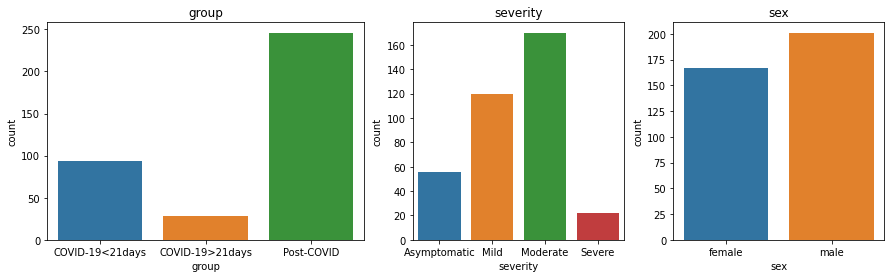

In [28]:
# Plot the distribution of patients in different groups, with different symptoms severity and with different gender. 

fig, axes = plt.subplots(nrows = 1,
                        ncols = 3,
                        figsize = (15,4),
                        gridspec_kw = {"wspace": 0.2,  # Sets the width of padding between subplots (is a fraction of the Axes width)
                                        "width_ratios": [ 1.5, 1, 1] # Sets relative width ratios between subplots 
                                       })

for i, ax in zip(range(0, 3), axes.flatten()):
    
    # List the features of interest
    feature=["group","severity", "sex"]
    
    # Plot the countplot
    sns.countplot(data = data, x=feature[i], ax=axes[i])
    
    # Add x/y labels and titles
    xticks = [['COVID-19<21days', 'COVID-19>21days', 'Post-COVID'], ['Asymptomatic', 'Mild', 'Moderate', 'Severe'], ['female', 'male']]
    ax.set_xticklabels(xticks[i])
    ax.set_title('{}'.format(feature[i]))

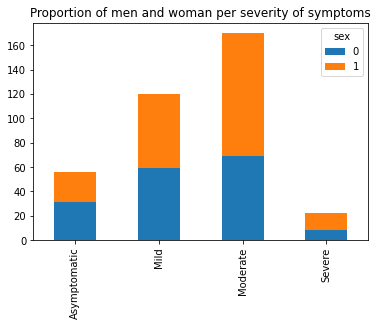

In [29]:
data_counts = data.groupby(['severity', 'sex']).size().reset_index().pivot(columns=['sex',], index='severity', values=0)
data_counts.index=['Asymptomatic', 'Mild', 'Moderate', 'Severe']
data_counts.plot(kind='bar', stacked=True)
plt.title("Proportion of men and woman per severity of symptoms")
plt.show()

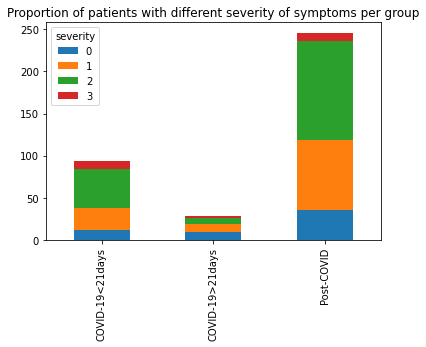

In [30]:
data_counts = data.groupby(['group', 'severity']).size().reset_index().pivot(columns=['severity',], index='group', values=0)
data_counts.index=['COVID-19<21days', 'COVID-19>21days', 'Post-COVID']
data_counts.plot(kind='bar', stacked=True)
plt.title("Proportion of patients with different severity of symptoms per group")
plt.show()

**Comment:** 
- The Dataset is imbalanced, there are 94 patients in group 0 (Post-COVID), 28 patients in group 1 (examined in the post-acute phase 'COVID-19>21days', so during the healing) and 246 patients in the group 2 (examined in the acute phase of infection).\
- The subjects have been classified according to the disease severity in the acute phase, not at the moment of the blood sample taking. \
- In each of the three groups, most patients had mild or moderate symptoms, some of them were asymptomatic and the minority had severe symptoms. \
- There is roughly an equal distribution of male and female accross different levels of severity of the symptoms. 

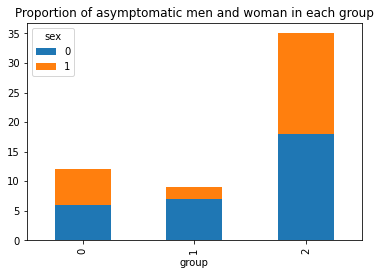

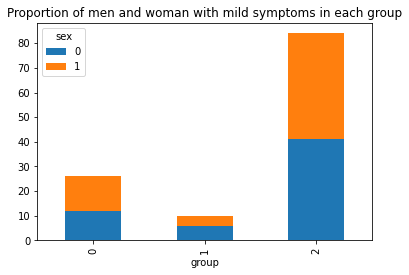

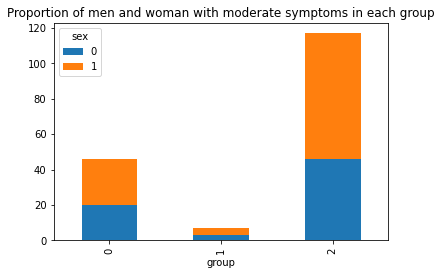

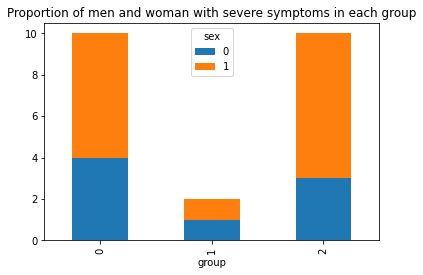

In [31]:
# Check whether female/female is more prevalent in certain severity classes (in the three groups)
severity=[0,1,2,3]
title=["Proportion of asymptomatic men and woman in each group",
      "Proportion of men and woman with mild symptoms in each group",
      "Proportion of men and woman with moderate symptoms in each group",
       "Proportion of men and woman with severe symptoms in each group"]

for i in range(0, 4):

    data_counts = data[data['severity']==severity[i]].groupby(['group', 'sex']).size().reset_index().pivot(columns=['sex',], index='group', values=0)
    data_counts.plot(kind='bar', stacked=True)
    plt.title(title[i])
    plt.show()

**Comment:** The proportion of male and female in the different severity classes in the three groups is similar, except in the post acute group of asymptomatic patients where majority are female. 

# Features exploration

## Numerical features values distribution and outliers

16


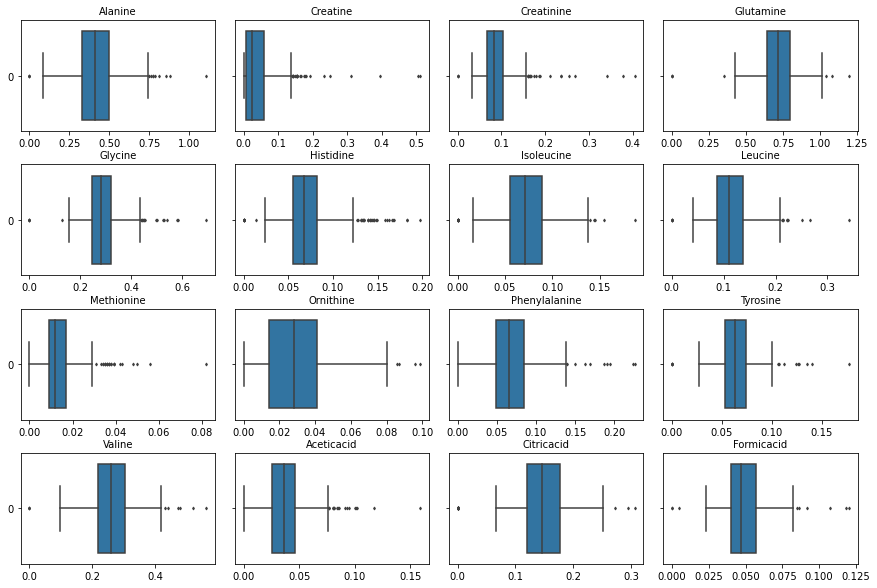

In [32]:
col_float64_batch1=col_float64[:16]
print(len(col_float64_batch1))

fig, axes = plt.subplots(nrows = 4,
                        ncols = 4,
                        figsize = (15,10),
                        gridspec_kw = ({"wspace": 0.1, "hspace": 0.3}), sharey=True)

# Plot distribution of the continuous variables  
for feat, ax in zip(col_float64_batch1, axes.ravel()):
    sns.boxplot(data=data[feat], orient="h", ax=ax, fliersize=2)
    ax.set_title('{}'.format(feat),fontsize=10)

In [33]:
# Check if the outliers correspond to a particular group of patients

# Choose columns of interest
col_identity=['sample_id', 'severity', 'group', 'sex', 'age']

substances_to_check=['Alanine', 'Phenylalanine', 'Valine', 'Creatine', 'Leucine', 'Ornithine', 'Tyrosine', 'Aceticacid']
treshold=[1, 0.2, 0.5, 0.45, 0.3, 0.09, 0.15, 0.13]
info_list=[]

for i in range (0, len(substances_to_check)):
    temp_list=list(data.loc[data[substances_to_check[i]]>treshold[i],col_identity].iloc[0,:])
    info_list.append(temp_list)
    
info_list_df=pd.DataFrame(info_list, columns=col_identity, index=substances_to_check)
info_list_df

,sample_id,severity,group,sex,age
Alanine,255,2,2,1,80
Phenylalanine,319,1,2,1,93
Valine,206,1,2,0,70
Creatine,262,2,2,0,89
Leucine,265,3,2,1,52
Ornithine,214,2,2,0,85
Tyrosine,233,2,2,1,70
Aceticacid,260,1,2,0,89


**Comment:** The most extreme outliers in severeal randomly chosen features correspond to patients from group 2 (acute phase of infection).

# Features encoding and save

In [35]:
# One-hot encoding of ordinal and nominal variables
data_ohe = pd.get_dummies(data, columns=["severity","sex","age_cat"]) 
print(data_ohe.shape)
data.to_csv('data.csv', index=False)
data_ohe.to_csv('data_ohe.csv', index=False)
data_ohe.head(5)

(368, 152)


,sample_id,group,age,Alanine,Creatine,Creatinine,Glutamine,Glycine,Histidine,Isoleucine,...,severity_0,severity_1,severity_2,severity_3,sex_0,sex_1,age_cat_0,age_cat_1,age_cat_2,age_cat_3
0,6,2,72,0.411,0.016,0.088,0.705,0.274,0.063,0.077,...,1,0,0,0,0,1,0,0,1,0
1,7,2,89,0.379,0.018,0.069,0.696,0.538,0.034,0.062,...,1,0,0,0,1,0,0,0,0,1
2,9,2,82,0.362,0.058,0.117,0.657,0.311,0.054,0.054,...,1,0,0,0,1,0,0,0,1,0
3,19,2,56,0.394,0.007,0.100,0.783,0.227,0.067,0.084,...,1,0,0,0,0,1,0,1,0,0
4,20,2,87,0.224,0.122,0.155,0.452,0.220,0.055,0.033,...,1,0,0,0,0,1,0,0,0,1
